# Running QFT on real IBM QC

In this Notebook I try to run my QFT code on a real IBM QC. I compare these simulations with the AerSimulator.

## Content1

1) 4 bit QFT run on IBM brisbane
2) 4 bit QFT simulated with AerSimulator without noise
3) 4 bit QFT simultaed with AerSimulator with noise added


In [1]:
import numpy as np
import sys
import math
import time
sys.path
sys.path.insert(0, 'C:/Users/Oleg/Google Диск/QC/Codes/QC-qiskit-codes/Shor')
sys.path.insert(0, 'C:/Users/Oleg/Google Диск/QC/Codes/QC-qiskit-codes/Library')

import qiskit
from qiskit import QuantumRegister as Q_R
from qiskit import ClassicalRegister as C_R
from qiskit_aer import Aer
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator

from qiskit_aer.noise import NoiseModel, depolarizing_error
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_aer.primitives import SamplerV2 as Sampler

import quantum_routines as qr
import aux_func as af

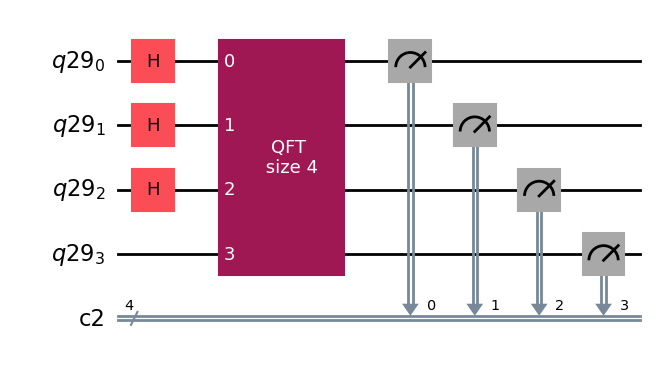

In [38]:
bit_size = 4

inp_num = [0, 0, 0, 0]

q_reg = Q_R(bit_size)
cl_reg = C_R(bit_size)
QFT = qiskit.QuantumCircuit(q_reg,cl_reg)

QFT = qr.qubit_binary_prepare(q_reg, inp_num, QFT)
QFT.h(0)
QFT.h(1)
QFT.h(2)


instr = qr.QFTn_instr(bit_size)
QFT.append(instr, q_reg)
QFT = qr.qubits_meas(q_reg, cl_reg, QFT)

QFT.draw('mpl')

In [12]:
QFT.decompose().depth()

9

In [5]:
from qiskit_ibm_runtime import QiskitRuntimeService
service = QiskitRuntimeService()
backend = service.least_busy(simulator=False, operational=True)
backend

<IBMBackend('ibm_brisbane')>

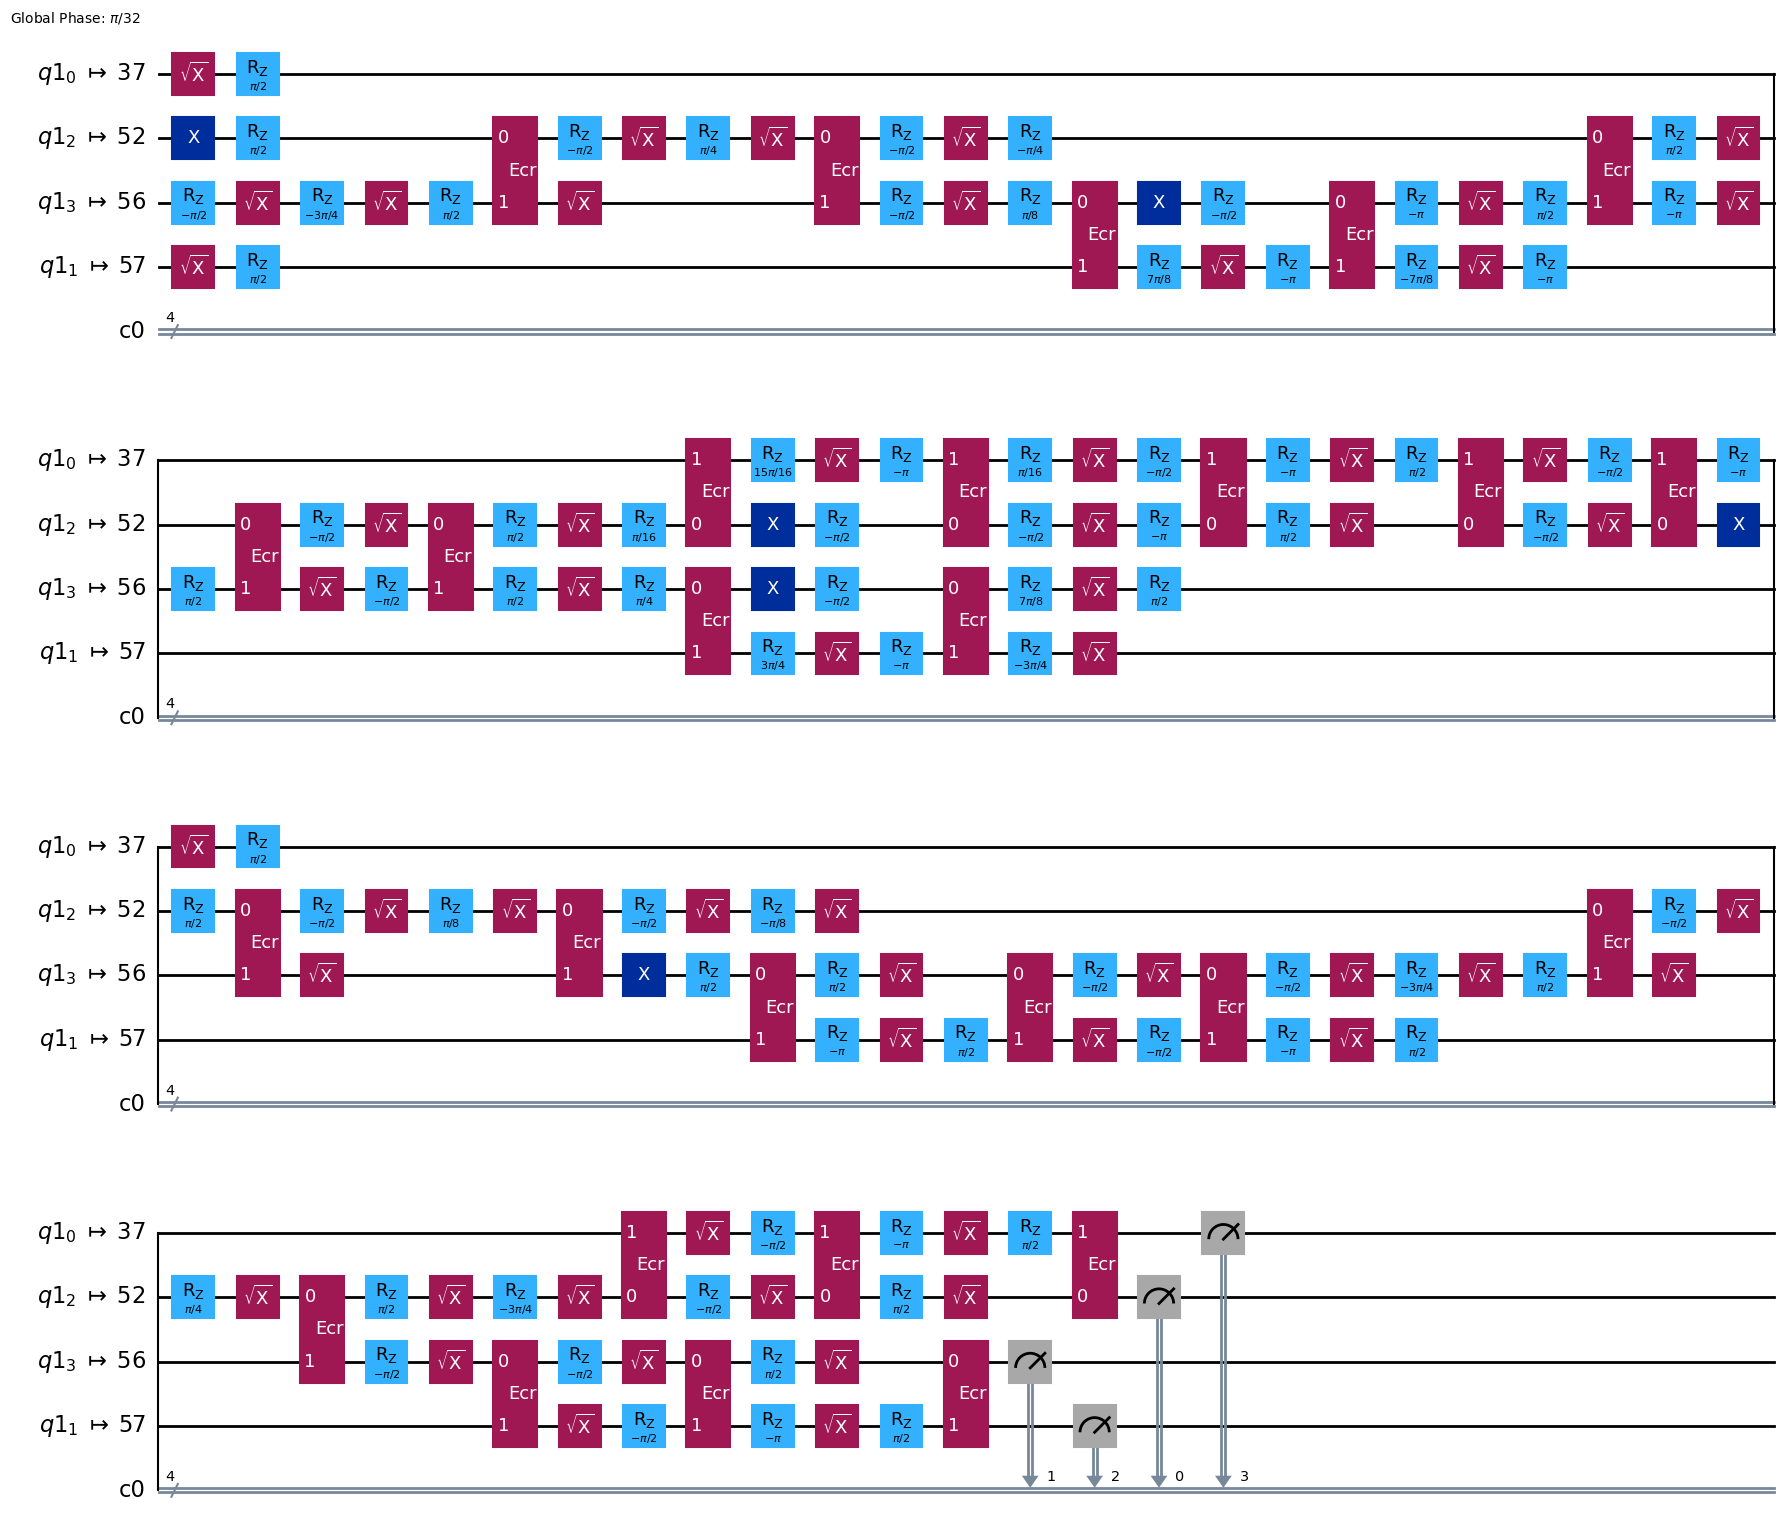

In [9]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(QFT)
isa_circuit.draw('mpl', idle_wires=False)


In [13]:
isa_circuit.depth()

91

In [16]:
from qiskit_ibm_runtime import SamplerV2 as Sampler
sampler = Sampler(mode=backend)
job = sampler.run([isa_circuit])
print(f">>> Job ID: {job.job_id()}")
print(f">>> Job Status: {job.status()}")



>>> Job ID: cwh9m7r31we00087yf40
>>> Job Status: QUEUED


In [17]:
print(f">>> Job ID: {job.job_id()}")
print(f">>> Job Status: {job.status()}")

>>> Job ID: cwh9m7r31we00087yf40
>>> Job Status: QUEUED


In [18]:
result = job.result()

In [36]:
pub_result = result[0]
pub_result
counts = result[0].data.c0.get_counts()
counts
#print(f"Counts for the meas output register: {pub_result.data.meas.get_counts()}")

{'1101': 92,
 '0000': 1464,
 '1110': 636,
 '0100': 180,
 '1111': 667,
 '0110': 113,
 '1100': 225,
 '0010': 103,
 '1001': 57,
 '1010': 47,
 '0111': 100,
 '0001': 196,
 '1000': 47,
 '0101': 49,
 '1011': 52,
 '0011': 68}

In [2]:
counts_IBM_brisbane_10_30 = {'1101': 92,
 '0000': 1464,
 '1110': 636,
 '0100': 180,
 '1111': 667,
 '0110': 113,
 '1100': 225,
 '0010': 103,
 '1001': 57,
 '1010': 47,
 '0111': 100,
 '0001': 196,
 '1000': 47,
 '0101': 49,
 '1011': 52,
 '0011': 68}

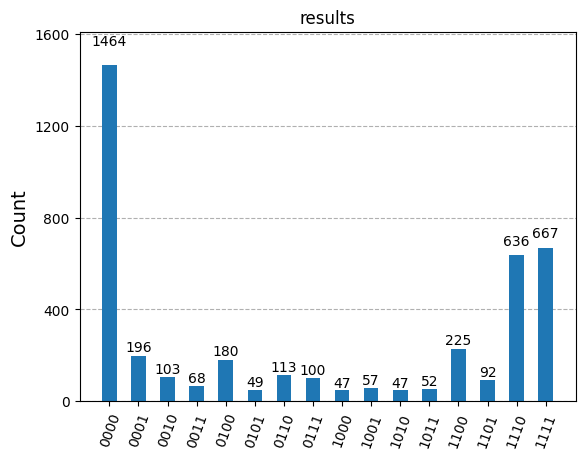

In [37]:
from qiskit.visualization import plot_histogram

plot_histogram(counts, title = 'results')

## AerSimulator. No noise


### Aer simulator

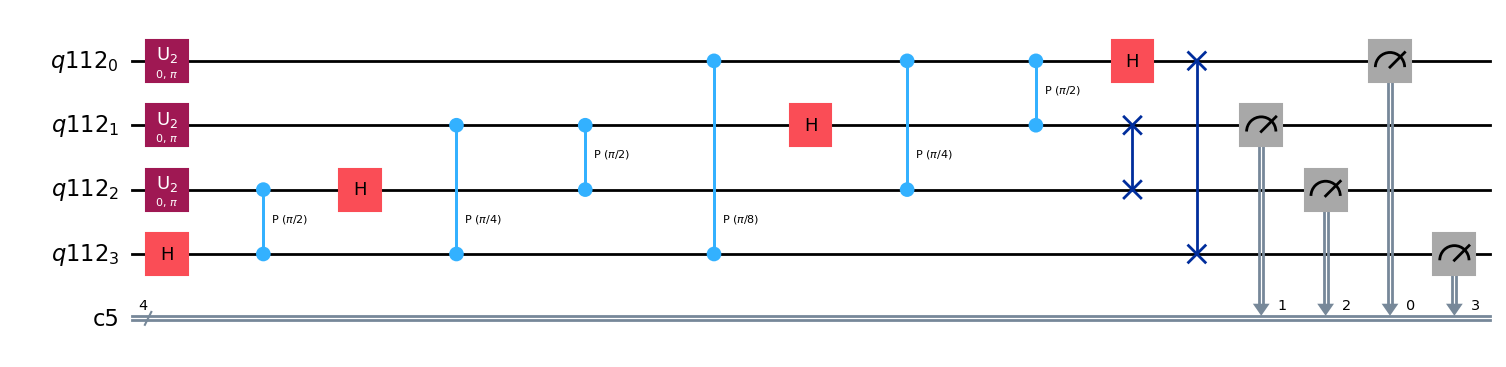

In [66]:
inp_num = [0, 0, 0, 0]
bit_size = 4
q_reg = Q_R(bit_size)
cl_reg = C_R(bit_size)
QFT = qiskit.QuantumCircuit(q_reg,cl_reg)

QFT = qr.qubit_binary_prepare(q_reg, inp_num, QFT)
QFT.h(0)
QFT.h(1)
QFT.h(2)


instr = qr.QFTn_instr(bit_size)
QFT.append(instr, q_reg)
QFT = qr.qubits_meas(q_reg, cl_reg, QFT)

QFT.decompose().draw('mpl')

['time elapsed: 0.01900005340576172 sec']


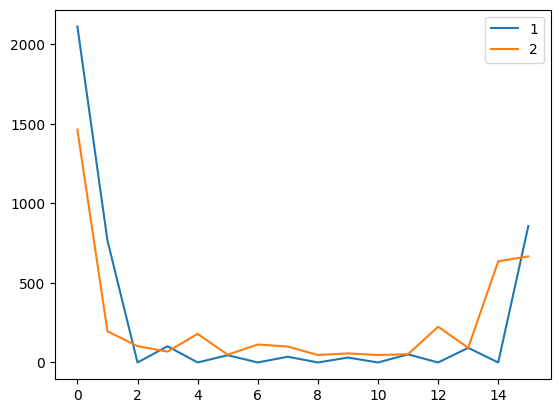

In [67]:
start = time.time()
shot_num = 4096
simulator = AerSimulator()
QFT = transpile(QFT, simulator)
result = simulator.run(QFT,shots = shot_num).result()
counts_ideal_sim = result.get_counts(QFT)
end = time.time()
print(['time elapsed: ' + str(end - start) + ' sec'])
af.plot_counts_2(counts_ideal_sim, counts_IBM_brisbane_10_30, bit_size)

## Classical fft

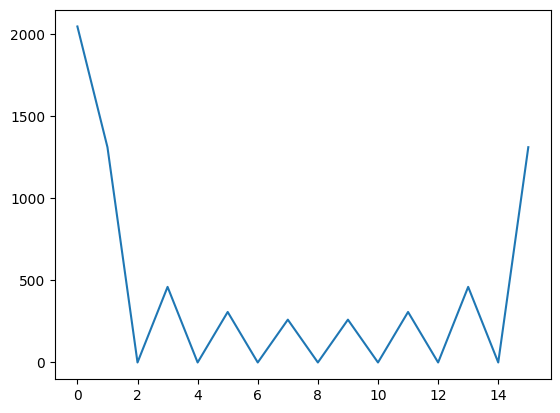

In [68]:
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft
import numpy as np
x = 256*np.array([1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0])
y = abs(fft(x))
plt.plot(range(16), y, label = ['1'])
plt.show()

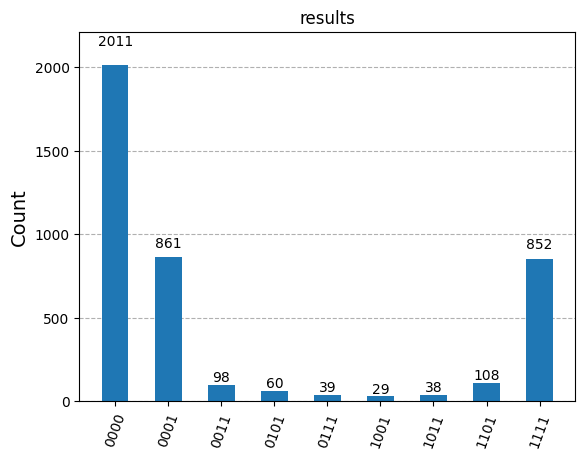

In [69]:
from qiskit.visualization import plot_histogram

plot_histogram(counts, title = 'results')

## IBM brisbane Vs Aer simulator

### IBM QC

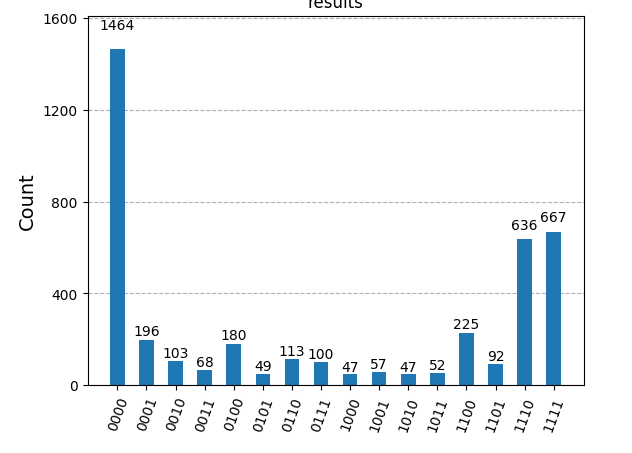

### Aer simulator

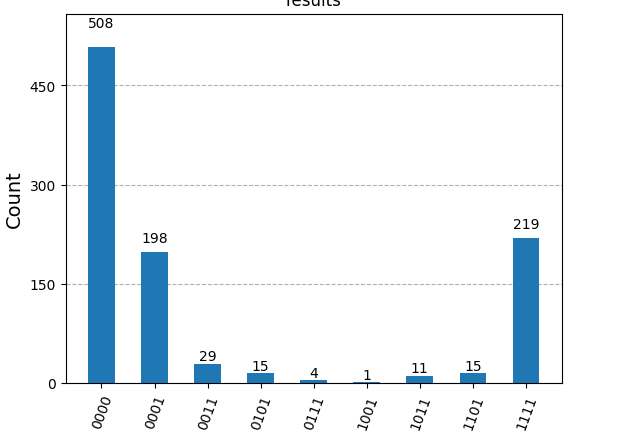

### IBM brisbane (orange) Vs AerSimulator (blue) on the same plot

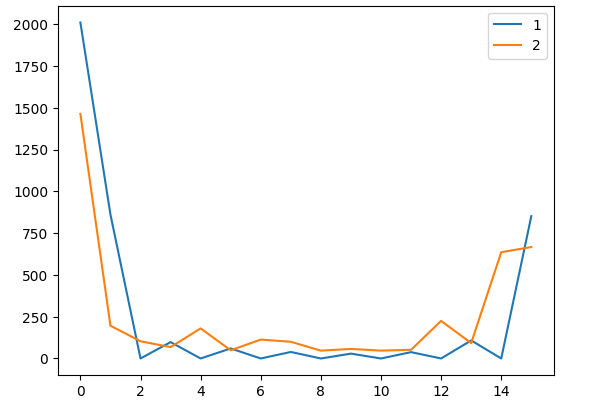


## Adding a noise to quantum simulations

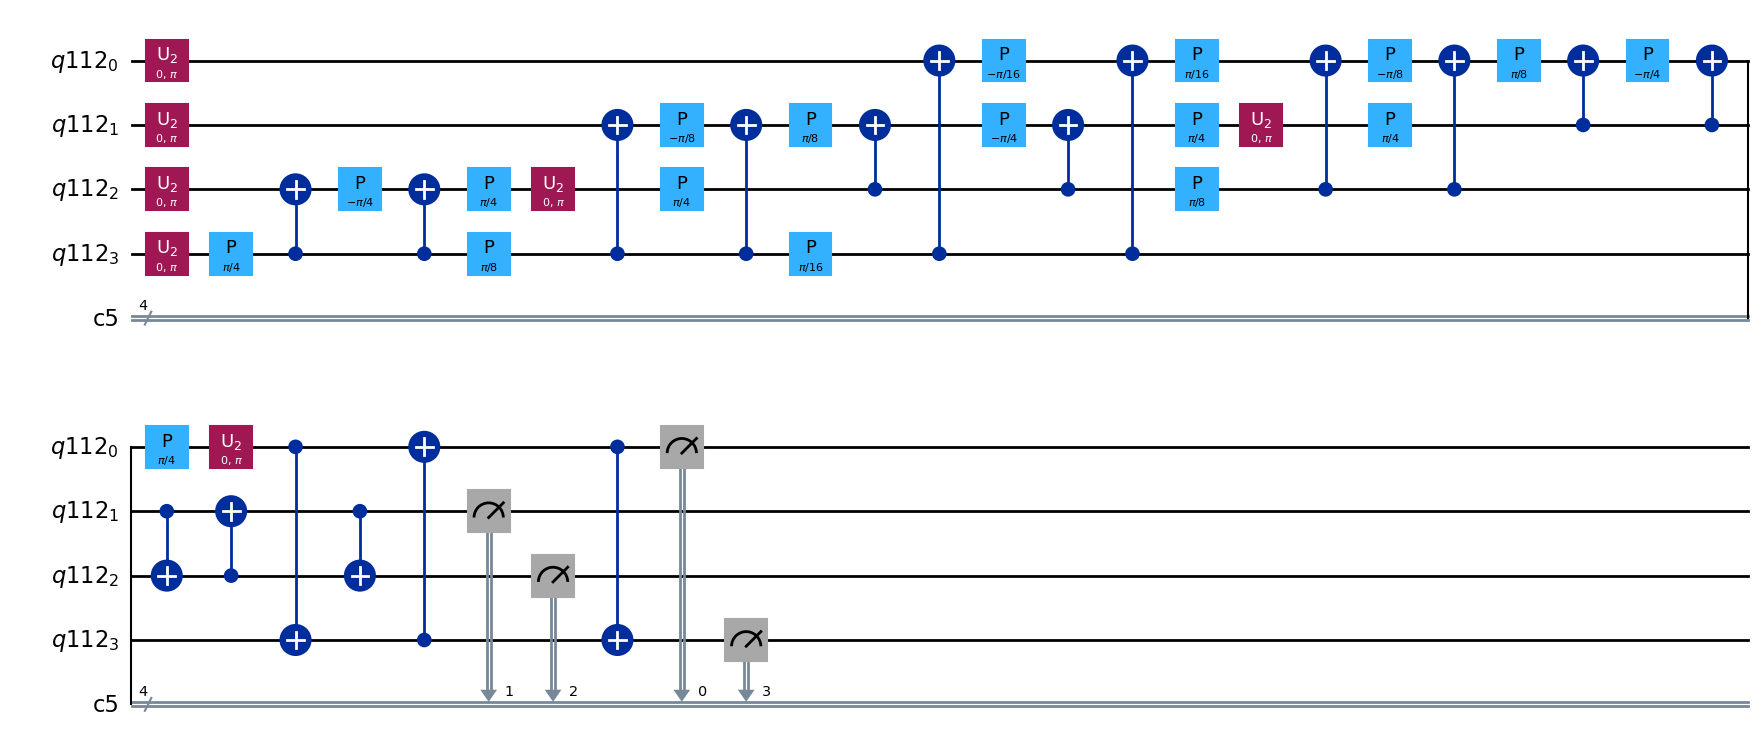

In [70]:
QFT1 = QFT.decompose()
QFT1.draw('mpl')

In [84]:
noise_model = NoiseModel()
cx_depolarizing_prob = 0.02
noise_model.add_all_qubit_quantum_error(
    depolarizing_error(cx_depolarizing_prob, 2), ["cx"]
)

pass_manager = generate_preset_pass_manager(3, AerSimulator())
isa_circuit = pass_manager.run(QFT1)
noisy_sampler = Sampler(options=dict(backend_options=dict(noise_model=noise_model)))
job = noisy_sampler.run([isa_circuit], shots = 4096)
result = job.result()
pub_result = result[0]
counts_noisy_sim = pub_result.data.c5.get_counts()


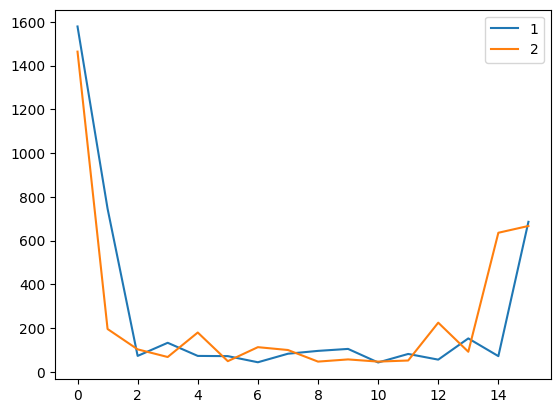

In [86]:
af.plot_counts_2(counts_noisy_sim, counts_IBM_brisbane_10_30, bit_size)

## Comparing noisy simulation and real quantum simulations

### Real (orange) vs Ideal simulations (blue)

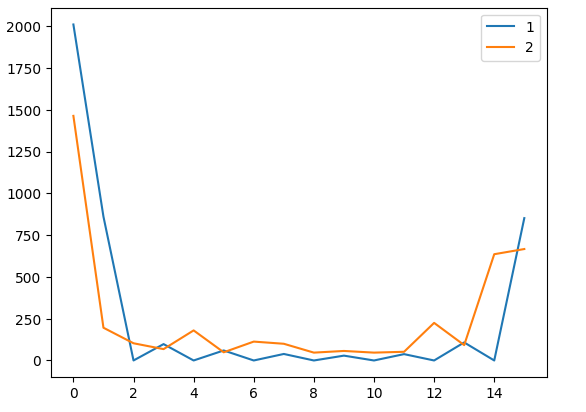

### Real (orange) vs Noisy simulations (blue). 0.02 error on cx gates

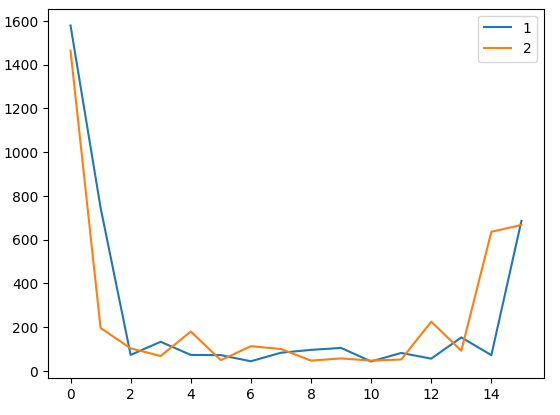


### Long circuit simulation

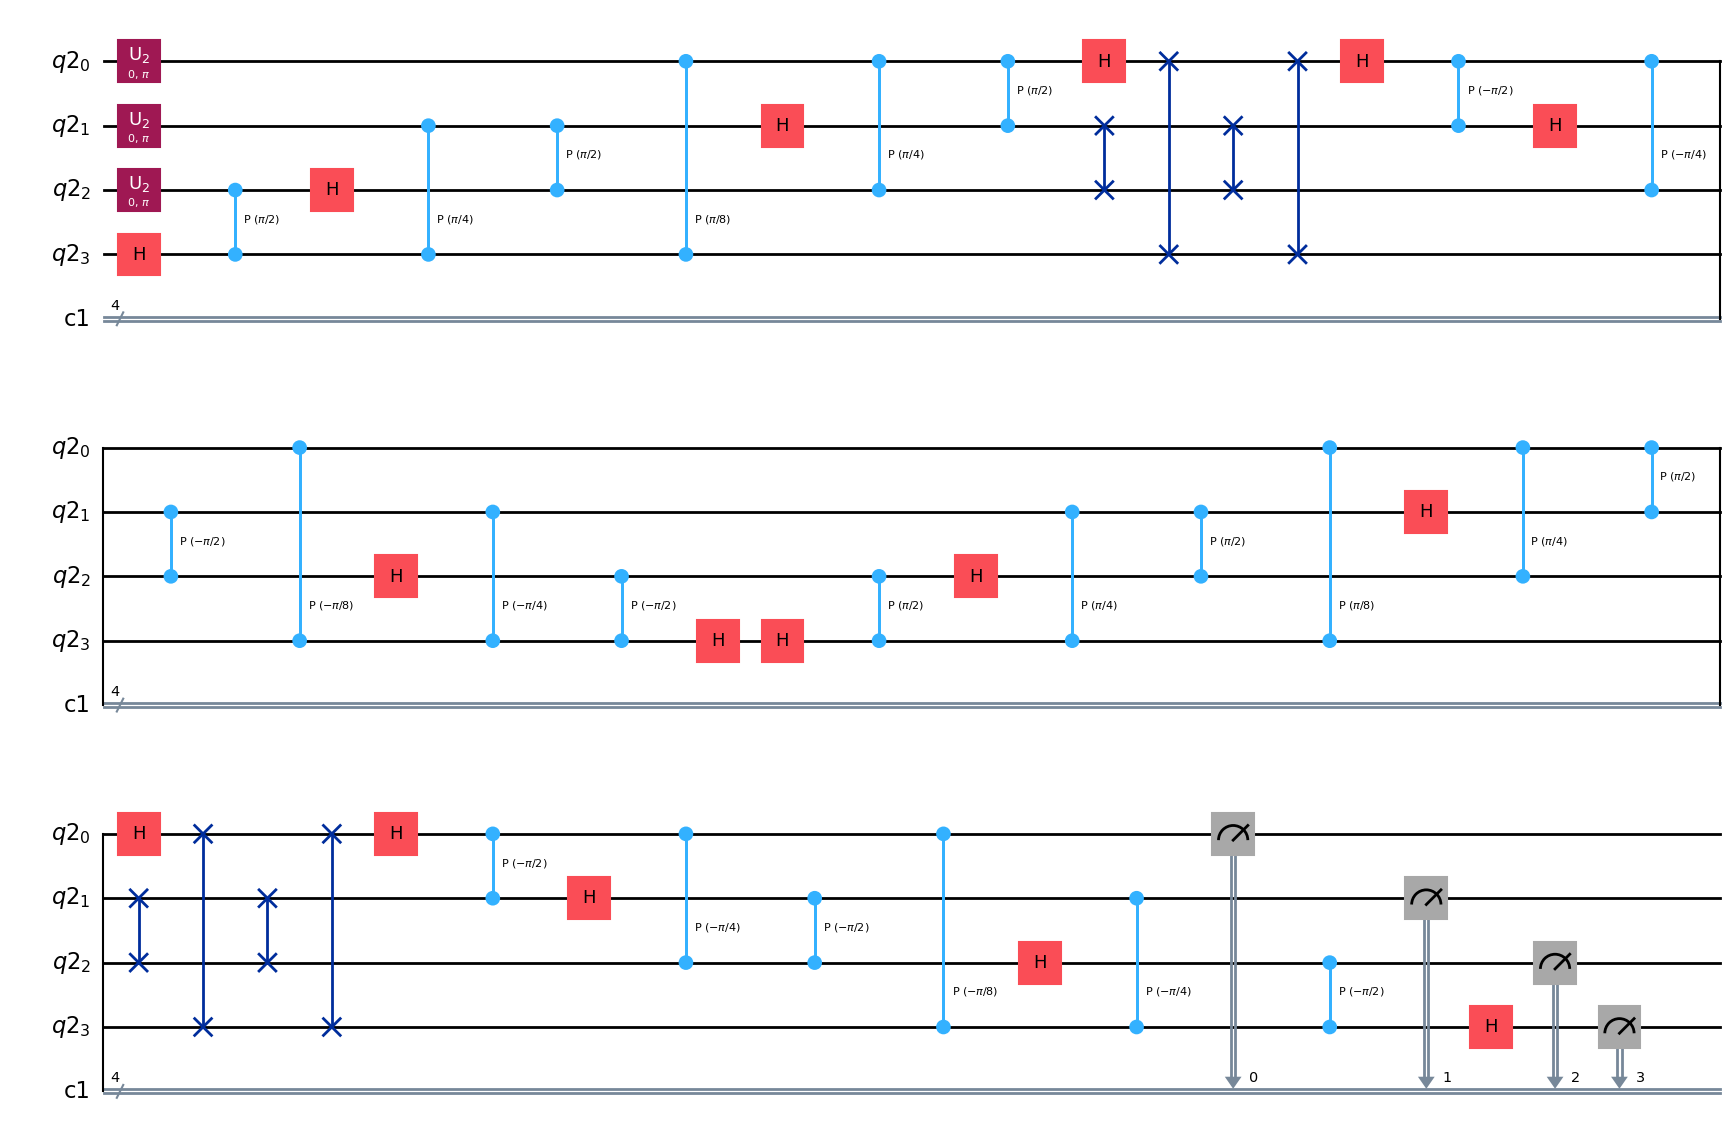

In [4]:
bit_size = 4

q_reg = Q_R(bit_size)
cl_reg = C_R(bit_size)
QFT_rep = qiskit.QuantumCircuit(q_reg,cl_reg)

QFT_rep.h(0)
QFT_rep.h(1)
QFT_rep.h(2)

rep_num = 2

for i in range (rep_num):
    instr = qr.QFTn_instr(bit_size)
    QFT_rep.append(instr, q_reg)    
    instr = qr.IQFTn_instr(bit_size)
    QFT_rep.append(instr, q_reg)
    
QFT_rep = qr.qubits_meas(q_reg, cl_reg, QFT_rep)

QFT_rep = QFT_rep.decompose()

QFT_rep.draw('mpl')

In [7]:
QFT_rep.clbits

[Clbit(ClassicalRegister(4, 'c1'), 0),
 Clbit(ClassicalRegister(4, 'c1'), 1),
 Clbit(ClassicalRegister(4, 'c1'), 2),
 Clbit(ClassicalRegister(4, 'c1'), 3)]

In [41]:
from qiskit_aer.noise import NoiseModel, pauli_error

noise_model = NoiseModel()
#error = depolarizing_error(0.4, 2)
error = pauli_error(2)
noise_model.add_all_qubit_quantum_error(error(error, 2), ["cx"])

pass_manager = generate_preset_pass_manager(3, AerSimulator())
isa_circuit = pass_manager.run(QFT_rep)
#print(isa_circuit.clbits)
noisy_sampler = Sampler(options=dict(backend_options=dict(noise_model=noise_model)))
job = noisy_sampler.run([isa_circuit], shots = 4096)
result = job.result()
pub_result = result[0]
counts_I = pub_result.data
counts_I = counts_I.c1.get_counts()


NoiseError: 'Input noise ops is not a list.'

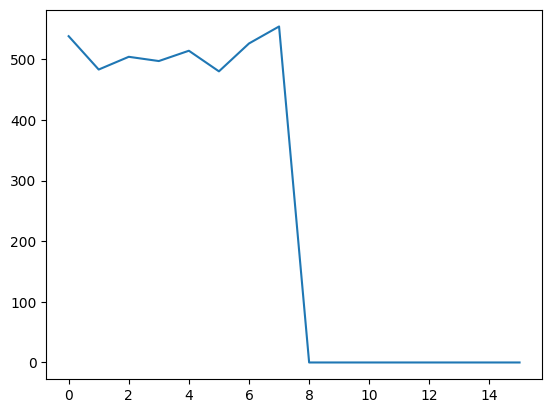

In [33]:
af.plot_counts(counts_I, bit_size)